# RFM-кластеризация покупателей (по CRISP-DM)
## Жуйков Алексей Валерианович ИВТ 1.2

## 1. Понимание бизнес-задачи (Business Understanding)

В этой лабораторной работе мы проведем сегментацию клиентов интернет-магазина на основе RFM-признаков (Recency, Frequency, Monetary). Цель – выявить группы покупателей с разными шаблонами покупательского поведения и предложить для каждого сегмента оптимальную стратегию взаимодействия.

In [36]:
# Исправление для Windows multiprocessing (должно быть выполнено в начале)
import os
if os.name == 'nt':  # Windows
    import multiprocessing
    try:
        multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass  # Метод уже установлен

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')  # Fallback для старых версий
sns.set_palette("husl")

# Импорт пользовательских модулей с обработкой ошибок
try:
    from data_preparation import DataPreparator
    from rfm_analysis import RFMAnalyzer
    from clustering_analysis import ClusteringAnalyzer
    from visualization_utils import VisualizationUtils
    print("Все модули успешно импортированы")
except ImportError as e:
    print(f"Ошибка импорта модулей: {e}")
    print("Убедитесь, что все файлы .py находятся в той же папке, что и ноутбук")

Все модули успешно импортированы


## 2. Понимание данных (Data Understanding)

In [38]:
# 2.1 Загрузка данных и структура таблицы

# TODO: загрузите данные из файла CSV в DataFrame
try:
    data = pd.read_csv('customer_segmentation_project.csv', encoding='ISO-8859-1')
    print("Данные успешно загружены")
except FileNotFoundError:
    print("Файл customer_segmentation_project.csv не найден!")
    print("Убедитесь, что файл находится в той же папке, что и ноутбук")
    # Создаем пример данных для демонстрации
    data = pd.DataFrame({
        'InvoiceNo': ['536365', '536365', '536366'],
        'StockCode': ['85123A', '71053', '84406B'],
        'Description': ['Product 1', 'Product 2', 'Product 3'],
        'Quantity': [6, 6, 8],
        'InvoiceDate': ['01/12/2010 08:26', '01/12/2010 08:26', '01/12/2010 08:28'],
        'UnitPrice': [2.55, 3.39, 2.75],
        'CustomerID': [17850.0, 17850.0, 17851.0],
        'Country': ['United Kingdom', 'United Kingdom', 'United Kingdom']
    })
    print("Используются демонстрационные данные")

# Общая информация о таблице
print("Размер данных:", data.shape)
print("\nТипы данных и наличие non-null:")
data.info()

# Просмотр первых 5 строк
data.head(5)

Данные успешно загружены
Размер данных: (541909, 8)

Типы данных и наличие non-null:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [39]:
# 2.2 Первичный обзор данных

print("Диапазон дат:", data['InvoiceDate'].min(), "до", data['InvoiceDate'].max())
print("Уникальных CustomerID:", data['CustomerID'].nunique())
print("Уникальных StockCode:", data['StockCode'].nunique())
print("Уникальных стран:", data['Country'].nunique())
print("\nТоп-5 стран по числу транзакций:")
print(data['Country'].value_counts().head())
print("\nПример кол-ва позиций в одном заказе (InvoiceNo=536365):")
print(data[data['InvoiceNo'] == '536365'].shape[0], "строк")
data[data['InvoiceNo'] == '536365'].head()

Диапазон дат: 1/10/2011 10:04 до 9/9/2011 9:52
Уникальных CustomerID: 4372
Уникальных StockCode: 4070
Уникальных стран: 38

Топ-5 стран по числу транзакций:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

Пример кол-ва позиций в одном заказе (InvoiceNo=536365):
7 строк


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [40]:
# 2.3 Поиск пропусков и дубликатов

# Количество пропусков в каждом столбце
print(data.isna().sum())

# Удаление записей без CustomerID или Description
print("Удаляем записи с пустым CustomerID или Description...")
initial_rows = data.shape[0]
data = data.dropna(subset=['CustomerID', 'Description'])
print(f"Удалено строк с пустым CustomerID/Description: {initial_rows - data.shape[0]}")

# Поиск и удаление полных дубликатов
print("Ищем полные дубликаты...")
initial_rows = data.shape[0]
data = data.drop_duplicates()
print(f"Удалено полных дубликатов: {initial_rows - data.shape[0]}")
print("Размер данных после очистки:", data.shape)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Удаляем записи с пустым CustomerID или Description...
Удалено строк с пустым CustomerID/Description: 135080
Ищем полные дубликаты...
Удалено полных дубликатов: 5225
Размер данных после очистки: (401604, 8)


In [41]:
# 2.4 Разведочный анализ: выбросы и аномалии

# Статистики Quantity и UnitPrice
print(data[['Quantity','UnitPrice']].describe(percentiles=[0.01,0.05,0.95,0.99]))

# Сколько транзакций с отрицательным Quantity (возвраты)?
print("Количество строк с Quantity < 0 (возвраты):", (data['Quantity'] < 0).sum())

# Сколько транзакций с ценой 0?
print("Количество строк с UnitPrice = 0 (бесплатно):", (data['UnitPrice'] == 0).sum())

# Пример очень больших Quantity
print("Топ-5 по Quantity:")
print(data.nlargest(5, 'Quantity')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice']])

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000
Количество строк с Quantity < 0 (возвраты): 8872
Количество строк с UnitPrice = 0 (бесплатно): 40
Топ-5 по Quantity:
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826     ASSTD DESIGN 3D PAPER STICKERS     12540   
421632    573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121    554868     22197               SMALL POPCORN HOLDER      4300   

        UnitPrice  
540421       2.0

## 3. Подготовка данных (Data Preparation)

In [42]:
# 3.1 Очистка: удаление пропусков и дубликатов

# Удалим транзакции с Quantity = 0 или UnitPrice = 0, если есть
initial_rows = data.shape[0]
data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)]
print(f"Удалено строк с Quantity=0 или UnitPrice=0: {initial_rows - data.shape[0]}")

# Проверим, сколько отрицательных Quantity осталось
print("Отрицательных Quantity осталось:", (data['Quantity'] < 0).sum())

Удалено строк с Quantity=0 или UnitPrice=0: 40
Отрицательных Quantity осталось: 8872


In [43]:
# 3.3 Создание признака TotalPrice (общая сумма по строке)

# TODO: создайте новый столбец TotalPrice = Quantity * UnitPrice
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

print("Создан столбец TotalPrice")
print("Статистики TotalPrice:")
print(data['TotalPrice'].describe())

# Проверим отрицательные TotalPrice (возвраты)
print(f"\nСтрок с отрицательной TotalPrice: {(data['TotalPrice'] < 0).sum()}")
print(f"Общая сумма возвратов: £{data[data['TotalPrice'] < 0]['TotalPrice'].sum():.2f}")

Создан столбец TotalPrice
Статистики TotalPrice:
count    401564.000000
mean         20.615691
std         430.373603
min     -168469.600000
25%           4.250000
50%          11.700000
75%          19.800000
max      168469.600000
Name: TotalPrice, dtype: float64

Строк с отрицательной TotalPrice: 8872
Общая сумма возвратов: £-608689.47


In [44]:
# Использование класса DataPreparator для дальнейшей подготовки данных
preparator = DataPreparator()
data_clean = preparator.prepare_data(data)

print(f"Подготовленные данные: {data_clean.shape}")
print("\nОбщая информация:")
data_clean.info()

Удалено 0 некорректных записей при валидации
Подготовленные данные: (393819, 9)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 393819 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    393819 non-null  object        
 1   StockCode    393819 non-null  object        
 2   Description  393819 non-null  object        
 3   Quantity     393819 non-null  int64         
 4   InvoiceDate  393819 non-null  datetime64[ns]
 5   UnitPrice    393819 non-null  float64       
 6   CustomerID   393819 non-null  int64         
 7   Country      393819 non-null  object        
 8   TotalPrice   393819 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


## 4. Расчет RFM показателей

In [45]:
# Создание RFM анализатора и расчет показателей
rfm_analyzer = RFMAnalyzer()
rfm_data = rfm_analyzer.calculate_rfm(data_clean)

print("RFM данные рассчитаны:")
print(f"Количество клиентов: {rfm_data.shape[0]}")
print("\nПример RFM данных:")
rfm_data.head()

RFM данные рассчитаны:
Количество клиентов: 4276

Пример RFM данных:


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
1,12347,2,7,4060.40,5,4,5,545
2,12348,75,4,1186.68,2,4,4,244
3,12349,19,1,1353.80,4,1,4,414
4,12350,310,1,294.40,1,1,2,112
5,12352,36,8,1265.41,3,5,4,354


Статистики RFM показателей:
           Recency    Frequency      Monetary
count  4276.000000  4276.000000  4.276000e+03
mean     90.456268     4.988307  1.571736e+03
std      99.272513     9.043823  4.705209e+03
min       1.000000     1.000000  1.776357e-15
25%      17.000000     1.000000  2.825625e+02
50%      49.000000     3.000000  6.225250e+02
75%     139.000000     5.000000  1.518047e+03
max     374.000000   242.000000  1.595072e+05


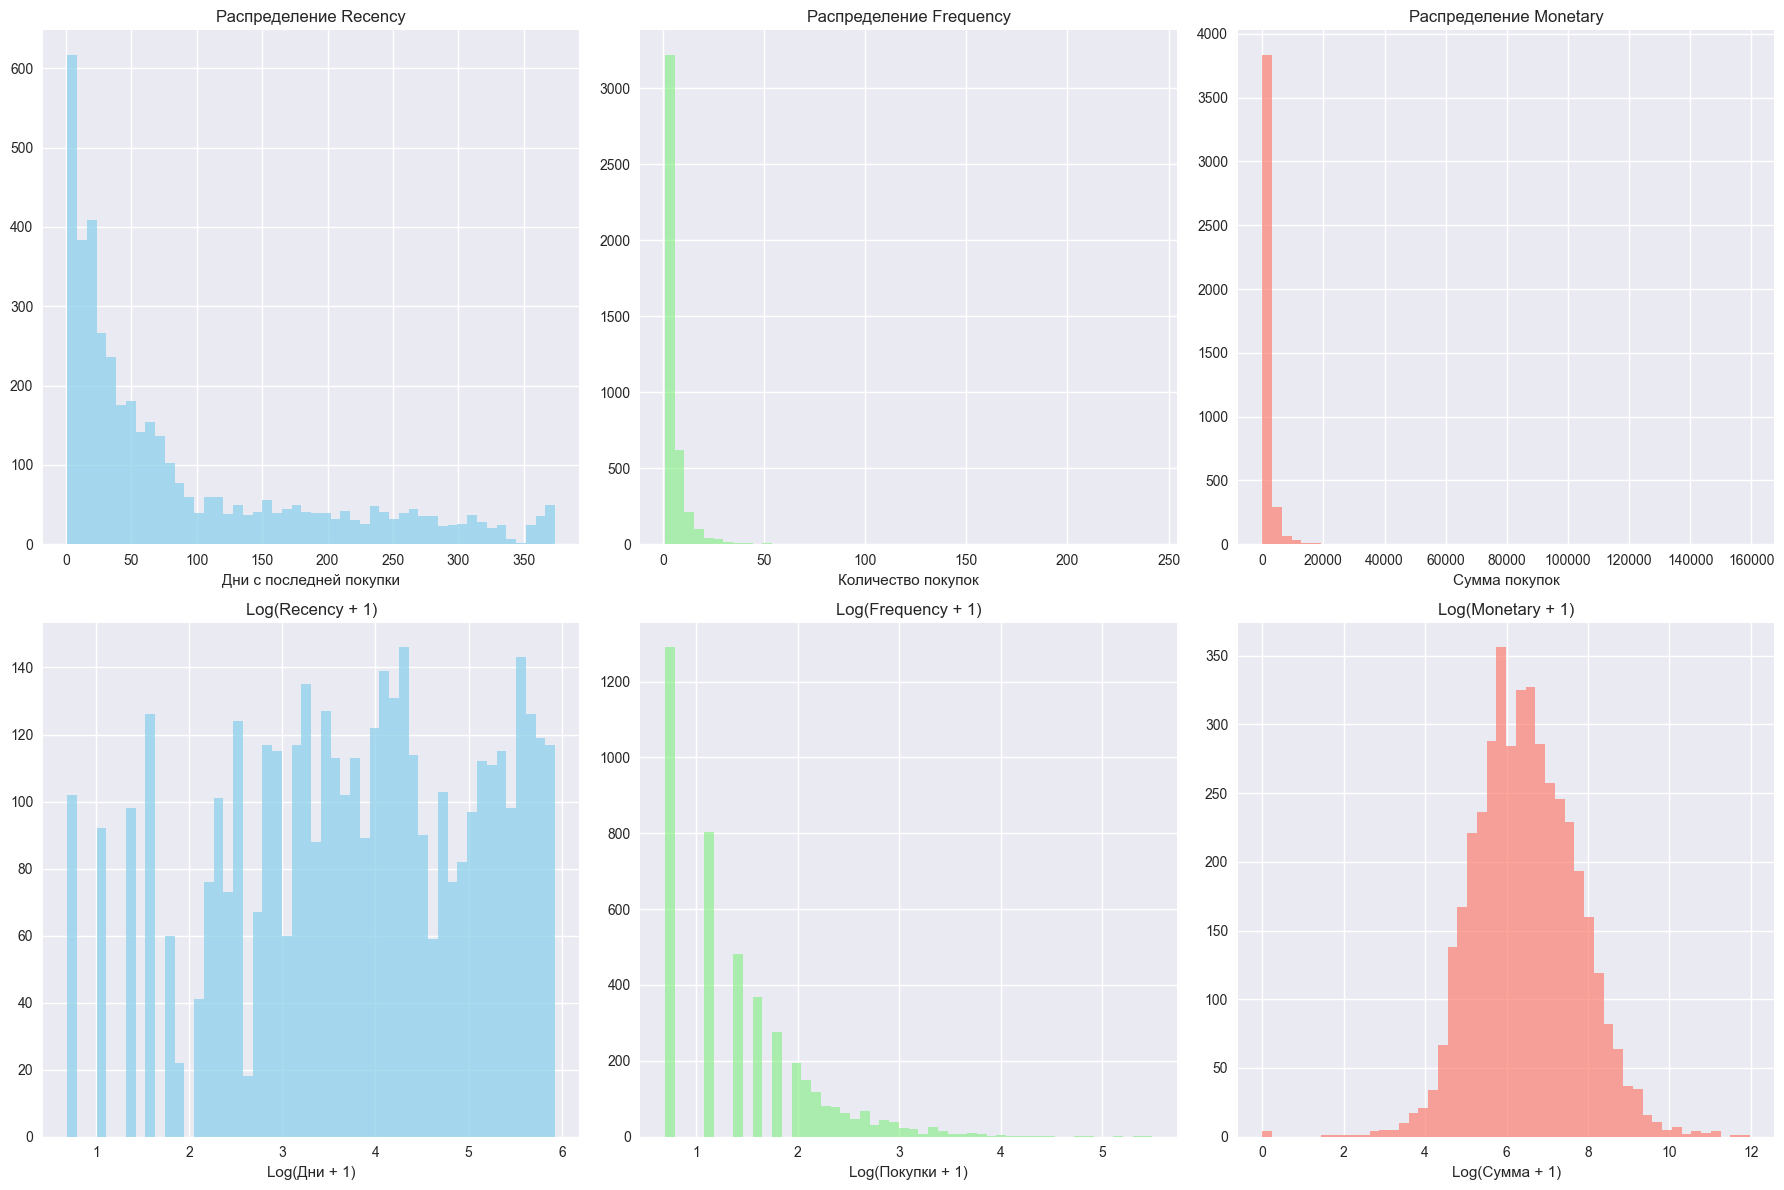

In [46]:
# Статистики RFM показателей
print("Статистики RFM показателей:")
print(rfm_data[['Recency', 'Frequency', 'Monetary']].describe())

# Визуализация распределений RFM
viz = VisualizationUtils()
viz.plot_rfm_distributions(rfm_data)

## 5. Моделирование (Clustering)

In [47]:
# Создание анализатора кластеризации
clustering_analyzer = ClusteringAnalyzer()

# Подготовка данных для кластеризации
rfm_scaled, scaler = clustering_analyzer.prepare_for_clustering(rfm_data)

print("Данные подготовлены для кластеризации")
print(f"Размер масштабированных данных: {rfm_scaled.shape}")

Данные подготовлены для кластеризации
Размер масштабированных данных: (4276, 3)


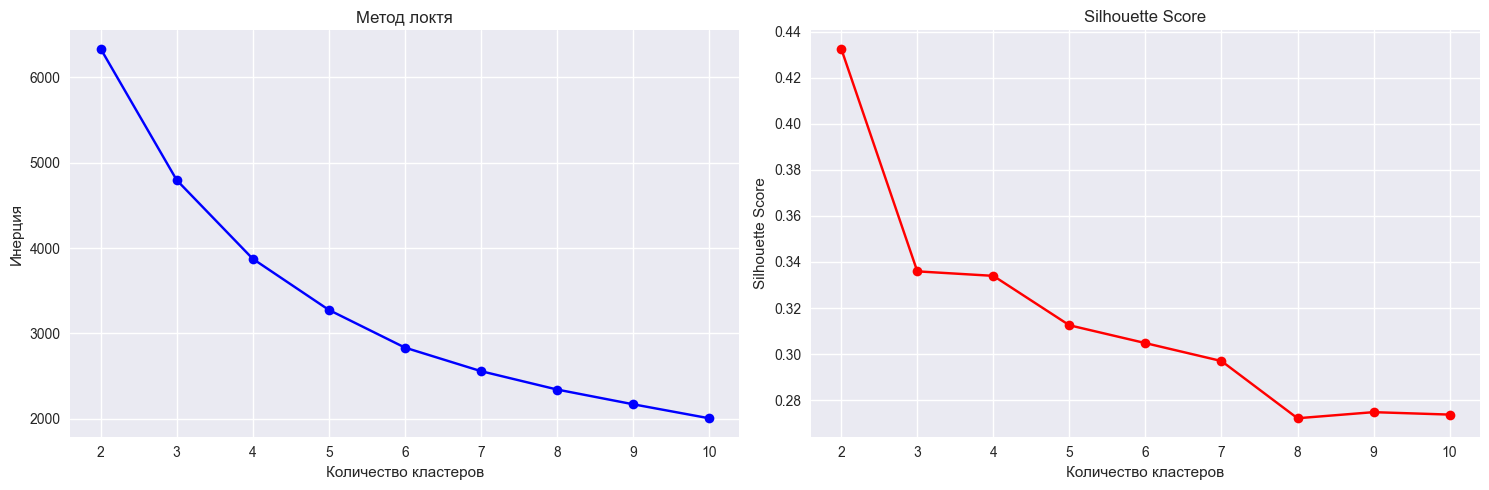

Рекомендуемое количество кластеров (по Silhouette): 2
Применены методы кластеризации:
K-means: 5 кластеров
Hierarchical: 5 кластеров
GMM: 5 кластеров
Spectral: 5 кластеров
DBSCAN: 2 кластеров + 57 шумовых точек


In [48]:
# Определение оптимального количества кластеров
try:
    clustering_analyzer.find_optimal_clusters(rfm_scaled, max_clusters=10)
except Exception as e:
    print(f"Ошибка при поиске оптимального количества кластеров: {e}")
    print("Используется значение по умолчанию: 5 кластеров")

# Применение различных методов кластеризации
try:
    results = clustering_analyzer.apply_clustering_methods(rfm_scaled, n_clusters=5)
    
    print("Применены методы кластеризации:")
    for method, labels in results.items():
        unique_labels = len(np.unique(labels))
        if method == 'DBSCAN' and -1 in labels:
            noise_points = np.sum(labels == -1)
            print(f"{method}: {unique_labels-1} кластеров + {noise_points} шумовых точек")
        else:
            print(f"{method}: {unique_labels} кластеров")
except Exception as e:
    print(f"Ошибка при применении методов кластеризации: {e}")
    # Создаем простую кластеризацию как fallback
    from sklearn.cluster import KMeans
    simple_kmeans = KMeans(n_clusters=5, random_state=42, n_jobs=1)
    results = {'K-means': simple_kmeans.fit_predict(rfm_scaled)}

## 6. Оценка и интерпретация результатов

In [49]:
# Оценка качества кластеризации
evaluation_results = clustering_analyzer.evaluate_clustering(rfm_scaled, results)

print("Результаты оценки кластеризации:")
for method, scores in evaluation_results.items():
    print(f"\n{method}:")
    for metric, score in scores.items():
        print(f"  {metric}: {score:.3f}")

Результаты оценки кластеризации:

K-means:
  silhouette: 0.313
  calinski_harabasz: 3114.301
  davies_bouldin: 1.041
  n_clusters: 5.000

Hierarchical:
  silhouette: 0.270
  calinski_harabasz: 2773.966
  davies_bouldin: 1.135
  n_clusters: 5.000

GMM:
  silhouette: 0.149
  calinski_harabasz: 1815.182
  davies_bouldin: 1.822
  n_clusters: 5.000

Spectral:
  silhouette: 0.507
  calinski_harabasz: 38.516
  davies_bouldin: 0.777
  n_clusters: 5.000

DBSCAN:
  silhouette: 0.243
  calinski_harabasz: 988.797
  davies_bouldin: 2.584
  n_clusters: 3.000


In [50]:
# Выбор лучшего метода (например, K-means) и добавление меток кластеров
best_method = 'K-means'  # TODO: выберите лучший метод на основе оценок
rfm_data['Cluster'] = results[best_method]

# Анализ характеристик кластеров
cluster_analysis = rfm_data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'count'])
print("Характеристики кластеров:")
print(cluster_analysis)

Характеристики кластеров:
            Recency               Frequency                  Monetary  \
               mean median count       mean median count         mean   
Cluster                                                                 
0         10.393983    9.0   698   5.024355    5.0   698  1319.573095   
1         39.642710   36.5   974   1.603696    1.0   974   346.603225   
2         84.376543   65.0   972   4.751029    4.0   972  1492.266166   
3         12.803536    8.0   509  19.701375   15.0   509  7241.877466   
4        224.748887  226.0  1123   1.438112    1.0  1123   289.840882   

                         
           median count  
Cluster                  
0        1099.240   698  
1         313.545   974  
2        1187.915   972  
3        4337.210   509  
4         244.800  1123  


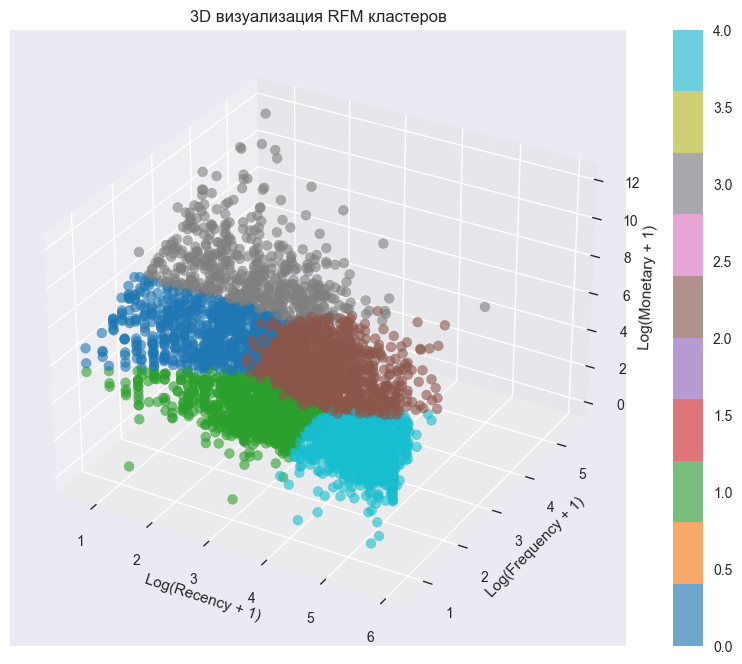

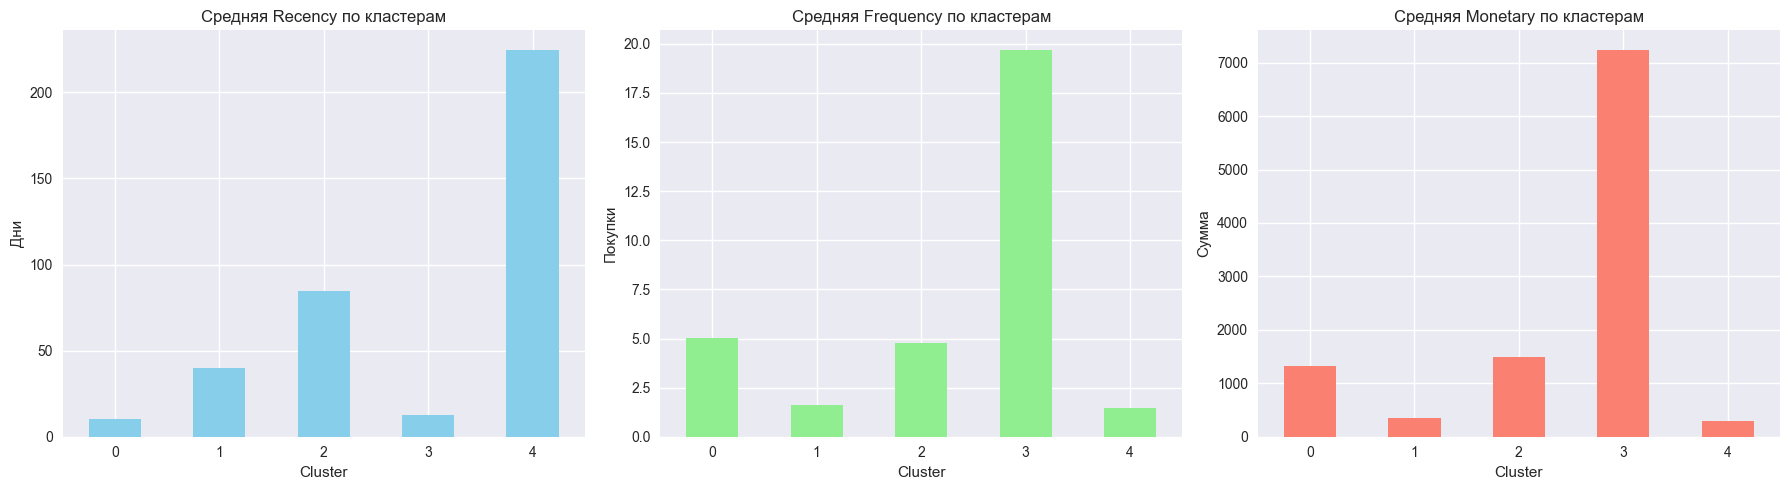

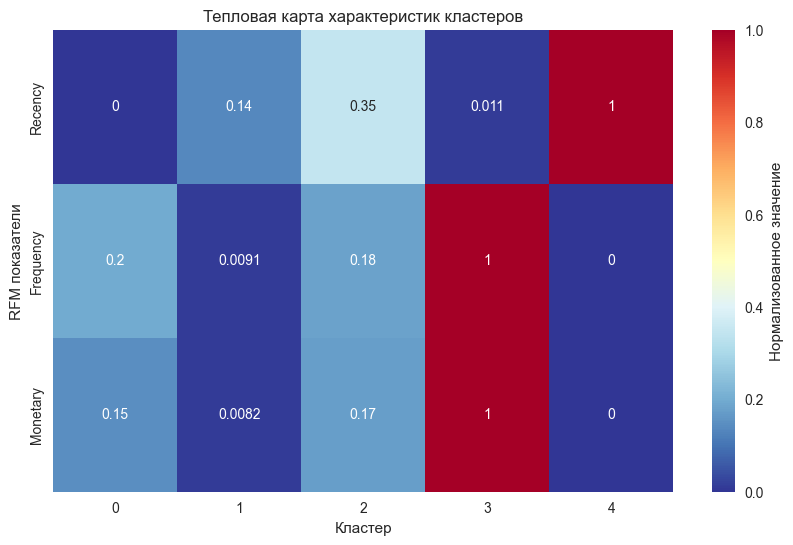

In [51]:
# Визуализация кластеров
viz.plot_clusters_3d(rfm_data)
viz.plot_cluster_characteristics(rfm_data)
viz.plot_cluster_heatmap(rfm_data)

## 7. Бизнес-интерпретация и рекомендации

In [52]:
# TODO: Интерпретация кластеров и создание бизнес-профилей
def interpret_clusters(rfm_data):
    """
    Интерпретация кластеров и создание бизнес-профилей
    """
    cluster_profiles = {}
    
    for cluster in sorted(rfm_data['Cluster'].unique()):
        cluster_data = rfm_data[rfm_data['Cluster'] == cluster]
        
        avg_recency = cluster_data['Recency'].mean()
        avg_frequency = cluster_data['Frequency'].mean()
        avg_monetary = cluster_data['Monetary'].mean()
        
        # Простая логика классификации
        if avg_recency <= 50 and avg_frequency >= 10 and avg_monetary >= 1000:
            profile = "VIP Клиенты"
            strategy = "Персональные предложения, эксклюзивные акции"
        elif avg_recency <= 100 and avg_frequency >= 5:
            profile = "Лояльные клиенты"
            strategy = "Программы лояльности, перекрестные продажи"
        elif avg_recency > 200:
            profile = "Потерянные клиенты"
            strategy = "Реактивационные кампании, специальные скидки"
        elif avg_frequency == 1:
            profile = "Новые клиенты"
            strategy = "Приветственные серии, онбординг"
        else:
            profile = "Развивающиеся клиенты"
            strategy = "Стимулирование повторных покупок"
        
        cluster_profiles[cluster] = {
            'profile': profile,
            'strategy': strategy,
            'size': len(cluster_data),
            'avg_recency': avg_recency,
            'avg_frequency': avg_frequency,
            'avg_monetary': avg_monetary
        }
    
    return cluster_profiles

profiles = interpret_clusters(rfm_data)

print("Профили кластеров и рекомендации:")
print("=" * 50)
for cluster, info in profiles.items():
    print(f"\nКластер {cluster}: {info['profile']}")
    print(f"Размер: {info['size']} клиентов")
    print(f"Средняя давность: {info['avg_recency']:.1f} дней")
    print(f"Средняя частота: {info['avg_frequency']:.1f} покупок")
    print(f"Средняя сумма: £{info['avg_monetary']:.2f}")
    print(f"Стратегия: {info['strategy']}")
    print("-" * 40)

Профили кластеров и рекомендации:

Кластер 0: Лояльные клиенты
Размер: 698 клиентов
Средняя давность: 10.4 дней
Средняя частота: 5.0 покупок
Средняя сумма: £1319.57
Стратегия: Программы лояльности, перекрестные продажи
----------------------------------------

Кластер 1: Развивающиеся клиенты
Размер: 974 клиентов
Средняя давность: 39.6 дней
Средняя частота: 1.6 покупок
Средняя сумма: £346.60
Стратегия: Стимулирование повторных покупок
----------------------------------------

Кластер 2: Развивающиеся клиенты
Размер: 972 клиентов
Средняя давность: 84.4 дней
Средняя частота: 4.8 покупок
Средняя сумма: £1492.27
Стратегия: Стимулирование повторных покупок
----------------------------------------

Кластер 3: VIP Клиенты
Размер: 509 клиентов
Средняя давность: 12.8 дней
Средняя частота: 19.7 покупок
Средняя сумма: £7241.88
Стратегия: Персональные предложения, эксклюзивные акции
----------------------------------------

Кластер 4: Потерянные клиенты
Размер: 1123 клиентов
Средняя давность: 224.

In [54]:
# Сохранение результатов
rfm_data.to_csv('rfm_customer_segments.csv', index=False)
print("\nРезультаты сохранены в файл 'rfm_customer_segments.csv'")

# Итоговая сводка
print("\n" + "=" * 60)
print("ИТОГОВАЯ СВОДКА RFM-АНАЛИЗА")
print("=" * 60)
print(f"Общее количество клиентов: {rfm_data.shape[0]}")
print(f"Количество сегментов: {rfm_data['Cluster'].nunique()}")
print(f"Период анализа: {data_clean['InvoiceDate'].min()} - {data_clean['InvoiceDate'].max()}")
print(f"Общая выручка: £{rfm_data['Monetary'].sum():.2f}")
print(f"Средний чек: £{rfm_data['Monetary'].mean():.2f}")



Результаты сохранены в файл 'rfm_customer_segments.csv'

ИТОГОВАЯ СВОДКА RFM-АНАЛИЗА
Общее количество клиентов: 4276
Количество сегментов: 5
Период анализа: 2010-12-01 08:26:00 - 2011-12-09 12:50:00
Общая выручка: £6720743.21
Средний чек: £1571.74
